## License Plate Recognition with OCR and CTC Loss

This OCR model, with CTC loss, presents a sophisticated solution for license plate recognition. By integrating advanced techniques, including Convolutional Neural Networks (CNNs) and Bidirectional LSTMs, this model excels in accurately identifying license plates from images. Designed with a focus on efficiency and accuracy, this solution has the potential to revolutionize various applications, from law enforcement to commercial services.



In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '20'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
from keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Conv2D, Reshape, Flatten, LSTM, Bidirectional, Dropout, Input, MaxPooling2D, Dense

### Load Dataset

In [2]:
data_dir = 'iclp-part1/'
file_paths = glob.glob('iclp-part1/*.jpg')
labels = [label.split('/')[1].split('_')[0] for label in file_paths]

In [3]:
print(len(labels))
print(len(file_paths))

3000
3000


### Dataset Description:

In this dataset, each image corresponds to a license plate, identified by the filename in the format `'11B39235_15685.jpg'`. The license plate number, such as `'11B39235'`, is extracted directly from the filename. This straightforward labeling method simplifies data organization and facilitates efficient training and evaluation of license plate recognition models.

In [4]:
characters = set(char for label in labels for char in label)
print(characters)
characters = sorted(list(characters))
len(characters)

{'5', 'S', 'Z', 'B', '8', 'D', 'V', '0', 'K', '6', '1', '2', 'H', 'T', 'L', 'A', 'J', '7', 'C', 'Y', 'N', '4', 'M', '3', 'X', '9'}


26

### Vectorize Labels:

Text vectorization is a crucial step in natural language processing (NLP), converting textual data into numerical vectors suitable for machine learning algorithms. In this snippet, the iclp_vec TextVectorization instance is being configured to tokenize and standardize text efficiently. By adapting to the provided labels, iclp_vec learns to process Unicode text effectively

In [5]:
iclp_vec = TextVectorization(
    max_tokens=None,
    standardize=None)

iclp_vec.adapt(tf.reshape(tf.strings.unicode_split(labels, 'UTF-8'), (-1, )))

In [6]:
iclp_vec.get_vocabulary()

['',
 '[UNK]',
 '1',
 '2',
 '7',
 '5',
 '3',
 '6',
 '9',
 '8',
 '4',
 'Z',
 'L',
 'M',
 'N',
 'K',
 'X',
 'D',
 'S',
 'Y',
 'J',
 'C',
 'B',
 'H',
 'V',
 '0',
 'T',
 'A']

In [8]:
iclp_vec.get_vocabulary().index('A')

27

In [9]:
iclp_vec.get_vocabulary()[27]

'A'

### Train-val split

In [10]:
train_path, val_path, train_label, val_label = train_test_split(file_paths, labels, test_size=0.1) 

### Image and Label Loading Function:

- The load_img_label function loads image files and corresponding labels.
- It reads the image file, decodes it, and preprocesses it for model input.
- The label is tokenized and reshaped for compatibility with the model architecture.

In [12]:
IMG_WIDTH = 256
IMG_HEIGHT = 65

def load_img_label(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)  
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    img = tf.transpose(img, perm=[1, 0, 2])  # Ensure correct shape for Conv2D input
    label = iclp_vec(tf.strings.unicode_split(label, 'UTF-8'))
    label = tf.reshape(label, (-1, ))
    return img, label

### Indices to String:

The indices_to_string function converts a sequence of indices into a string. It retrieves characters from the vocabulary based on the provided indices, joins them into a string, and decodes it from UTF-8 encoding.

In [13]:
def indices_to_string(indices):
    chars = [iclp_vec.get_vocabulary()[idx] for idx in indices.numpy().flatten()]
    return tf.strings.reduce_join(chars).numpy().decode('UTF-8')

### Create Pipline

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 32
shuffle_buffer = 1000

dataset = tf.data.Dataset.from_tensor_slices((train_path, train_label))
training = dataset.map(load_img_label, num_parallel_calls=AUTOTUNE)
training = training.shuffle(buffer_size=shuffle_buffer)
training = training.batch(batch_size, num_parallel_calls=AUTOTUNE)
training = training.prefetch(AUTOTUNE)

dataset = tf.data.Dataset.from_tensor_slices((val_path, val_label))
validation = dataset.map(load_img_label, num_parallel_calls=AUTOTUNE)
validation = validation.batch(batch_size, num_parallel_calls=AUTOTUNE)
validation = validation.prefetch(AUTOTUNE)

### visualization

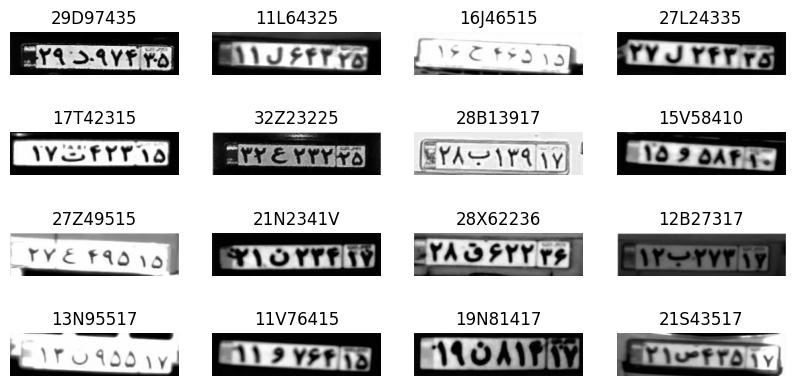

In [15]:
fig, ax = plt.subplots(4, 4, figsize=(10, 5))

for images, labels in training.take(1):
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap='gray')
        ax[i // 4, i % 4].set_title(indices_to_string(labels[i]))
        ax[i // 4, i % 4].axis("off")


### CTC Loss Function:

The CTCLoss function computes the CTC loss between predicted and true label sequences.

It adjusts input and label lengths to match the batch size and calculates the loss using keras.backend.ctc_batch_cost.



In [16]:
def CTCLoss(y_true, y_pred):
 
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

### License Plate Recognition Model:

The `Mymodel` class is a convolutional neural network (CNN) with a bidirectional Long Short-Term Memory (LSTM) layer for license plate recognition.

1. **CNN Layers**: Two convolutional layers (`Conv1` and `Conv2`) followed by max-pooling layers (`Max_pool1` and `Max_pool2`) extract features from the input images.

2. **Reshaping**: The output of the convolutional layers is reshaped to prepare it for input into the bidirectional LSTM layer.

3. **Dense Layers**: A dense layer (`Dense1`) with ReLU activation and dropout regularization is applied to the reshaped features.

4. **Bidirectional LSTM**: The bidirectional LSTM layer (`LSTM1`) captures temporal dependencies in the features extracted by the CNN layers.

5. **Output Layer**: A dense layer (`Dense2`) with softmax activation produces the output probabilities for each character in the license plate.

### Model Architecture:

The model architecture comprises convolutional and LSTM layers, enabling it to learn spatial and temporal features crucial for accurate license plate recognition.


In [17]:
class Mymodel(keras.models.Model):
    def __init__(self, vocab_size, filters_conv, filter_dense, lstm_units, dropout_rate):
        super(Mymodel, self).__init__()

        self.conv1 = Conv2D(
            filters_conv[0], 
            (3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            padding="same",
            name="Conv1")

        self.max_pool1 = MaxPooling2D((2, 2), name='Max_pool1')

        self.conv2 = Conv2D(
            filters_conv[1], 
            (3, 3),
            activation="relu",
            kernel_initializer="he_normal",
            padding="same",
            name="Conv2")

        self.max_pool2 = MaxPooling2D((2, 2), name='Max_pool2')

        new_shape = ((IMG_WIDTH // 4), (IMG_HEIGHT // 4) * filters_conv[1])
        self.reshape = Reshape(target_shape=new_shape, name="reshape")

        self.dense1 = Dense(filter_dense, activation='relu', name='Dense1')
        self.dropout = Dropout(dropout_rate)

        self.Bi_LSTM1 = Bidirectional(LSTM(lstm_units[0], return_sequences=True, dropout=0.25), name='LSTM1')

        self.dense2 = Dense(vocab_size + 1, activation='softmax', name='Dense2')


    def build(self, input_shape):
        input_image = Input(shape=input_shape[1:], dtype="float32", name="image")
        self.call(input_image)
        self.built = True

    def call(self, inputs, training=False):
        
        x = self.conv1(inputs)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = self.max_pool2(x)
        x = self.reshape(x)
        x = self.dense1(x)
        x = self.dropout(x, training=training)
        x = self.Bi_LSTM1(x, training=training)
        x = self.dense2(x)

        return x


In [18]:
VOCAB_SIZE = iclp_vec.vocabulary_size()
FLITERS_CONV = [64, 128]
FILTER_DENSE = 128
LSTM_UNITS = [128, 128]
DROPOUT_RATE = 0.3
    
model = Mymodel(VOCAB_SIZE, FLITERS_CONV, FILTER_DENSE, LSTM_UNITS, DROPOUT_RATE)
model.build(input_shape=(None, IMG_WIDTH, IMG_HEIGHT, 1))
model.summary()

Model: "mymodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 256, 65, 64)       640       
                                                                 
 Max_pool1 (MaxPooling2D)    (None, 128, 32, 64)       0         
                                                                 
 Conv2 (Conv2D)              (None, 128, 32, 128)      73856     
                                                                 
 Max_pool2 (MaxPooling2D)    (None, 64, 16, 128)       0         
                                                                 
 reshape (Reshape)           (None, 64, 2048)          0         
                                                                 
 Dense1 (Dense)              (None, 64, 128)           262272    
                                                                 
 dropout (Dropout)           (None, 64, 128)           0   

### Train the Model

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=CTCLoss)

### Early Stopping Callback:

The early_stopping callback is configured to monitor the validation loss during training. It halts training if the validation loss does not improve for early_stopping_patience epochs, restoring the best weights obtained during training.

In [20]:
early_stopping_patience = 10
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

history = model.fit(
    training,
    validation_data=validation,
    epochs=100,
    callbacks=[early_stopping],
)


Epoch 1/100


I0000 00:00:1717416870.791458   25542 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


85/85 [==============================] - 8s 40ms/step - loss: 31.0619 - val_loss: 23.0748
Epoch 2/100
85/85 [==============================] - 2s 28ms/step - loss: 21.6734 - val_loss: 21.4224
Epoch 3/100
85/85 [==============================] - 2s 28ms/step - loss: 20.8327 - val_loss: 20.6007
Epoch 4/100
85/85 [==============================] - 2s 28ms/step - loss: 20.1860 - val_loss: 20.4014
Epoch 5/100
85/85 [==============================] - 2s 28ms/step - loss: 19.7582 - val_loss: 20.0269
Epoch 6/100
85/85 [==============================] - 2s 28ms/step - loss: 19.4327 - val_loss: 19.6624
Epoch 7/100
85/85 [==============================] - 2s 28ms/step - loss: 19.1338 - val_loss: 19.1255
Epoch 8/100
85/85 [==============================] - 2s 28ms/step - loss: 18.6121 - val_loss: 17.9729
Epoch 9/100
85/85 [==============================] - 2s 28ms/step - loss: 17.1737 - val_loss: 15.2381
Epoch 10/100
85/85 [==============================] - 2s 28ms/step - loss: 14.0599 - val_loss:

### Batch Prediction and Visualization:

- **Decoding Predictions:** The decode_batch_predictions function decodes the predictions (pred) generated by the model. It utilizes the CTC decoding algorithm to convert the predictions into text format, truncating to a maximum length of `MAX_LEN`.

1/1 [==============================] - 0s 13ms/step


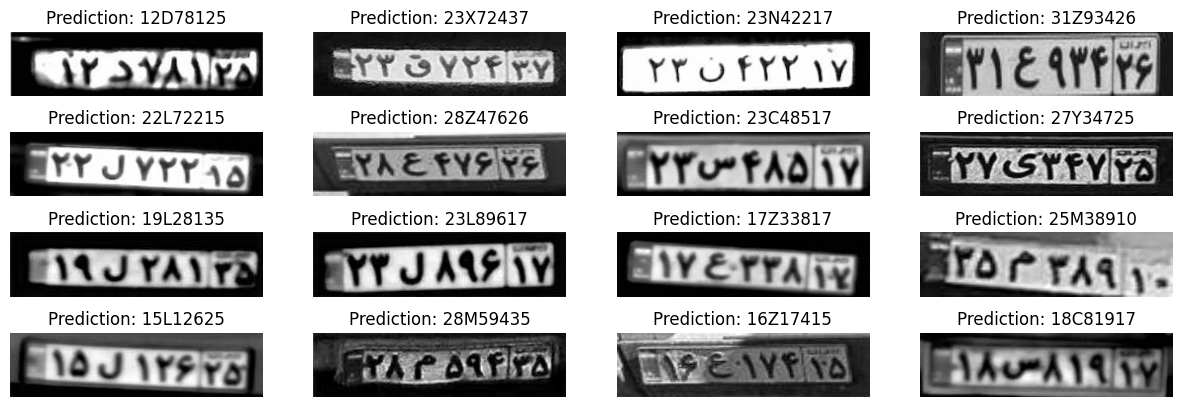

In [26]:
MAX_LEN = 8

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :MAX_LEN
    ]
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(indices_to_string(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

for batch_images, batch_labels in validation.take(1):

    preds = model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(16):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()